# Modelling outliers and special events with dummy variables

[Feature Engineering for Time Series Forecasting](https://www.trainindata.com/p/feature-engineering-for-forecasting)

In this notebook we show how modelling an outlier or special event can improve a forecast.

We will work with a monthly retail sales dataset (found [here](https://raw.githubusercontent.com/facebook/prophet/master/examples/example_retail_sales.csv)).

For instructions on how to download, prepare, and store the dataset, refer to notebook number 1, in the folder "01-Datasets" from this repo.

## Data Set Synopsis

The timeseries is between January 1992 and Apr 2005.

It consists of a single series of monthly values representing sales volumes. 

In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_context("talk")

# Load data

In [2]:
# Load retail sales dataset with the artificially added outliers
df = pd.read_csv(
    "../Datasets/example_retail_sales_with_outliers.csv",
    parse_dates=["ds"],
    index_col=["ds"],
)

# Plot the data to visually inspect any outliers

Text(0.5, 0, 'Time')

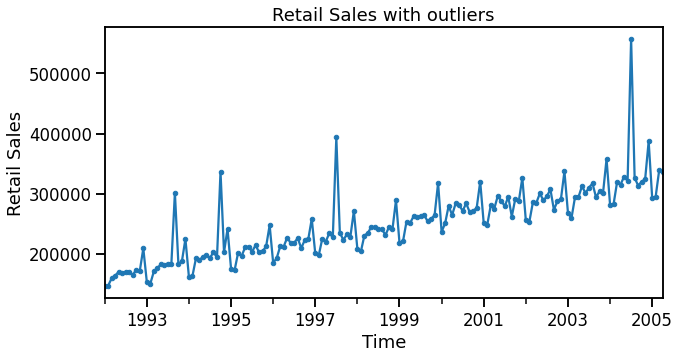

In [3]:
fig, ax = plt.subplots(figsize=[10, 5])
df.plot(y="y", marker=".", figsize=[10, 5], legend=None, ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")

For this exercise, assume we know the cause of these outliers and therefore we know the dates in the past and future. We're just trying to see the impact of outliers on a model in this notebook.

In [4]:
outlier_dates = [datetime.date(1993, 9, 1),
                 datetime.date(1994, 10, 1),
                 datetime.date(1997, 7, 1),
                 datetime.date(2004, 7, 1)]

# Create dummy variable

In [5]:
df["is_outlier"] = np.where(df.index.isin(outlier_dates), 1, 0)

Let's check the dummy variable.

In [6]:
df.loc["1993"]

,y,is_outlier
ds,,
1993-01-01,153221.0,0
1993-02-01,150087.0,0
1993-03-01,170439.0,0
1993-04-01,176456.0,0
1993-05-01,182231.0,0
1993-06-01,181535.0,0
1993-07-01,183682.0,0
1993-08-01,183318.0,0
1993-09-01,301590.2,1


# Add a trend feature

We will now add a feature to just model the trend. We will go into trend features in far more detail in the Trend and Seasonality section of the course. Our focus is on how outliers can impact our forecasts.

We can model the trend with a feature that represents time $t$ that has passed since any arbitrary time of our choice, we choose the start our time series. We are working with monthly data so we will measure time in months.

As the time series has no gaps, this can easily be done as follows:

In [7]:
df["trend"] = np.arange(0, len(df))

In [8]:
df

,y,is_outlier,trend
ds,,,
1992-01-01,146376.0,0,0
1992-02-01,147079.0,0,1
1992-03-01,159336.0,0,2
1992-04-01,163669.0,0,3
1992-05-01,170068.0,0,4
...,...,...,...
2004-12-01,387155.0,0,155
2005-01-01,293261.0,0,156
2005-02-01,295062.0,0,157


# Split into train and test

We will train the data up to the end of 2003 and predict all the data after that.

In [9]:
df_train = df[df.index < "2004-01-01"] 
df_test =df[df.index >= "2004-01-01"]

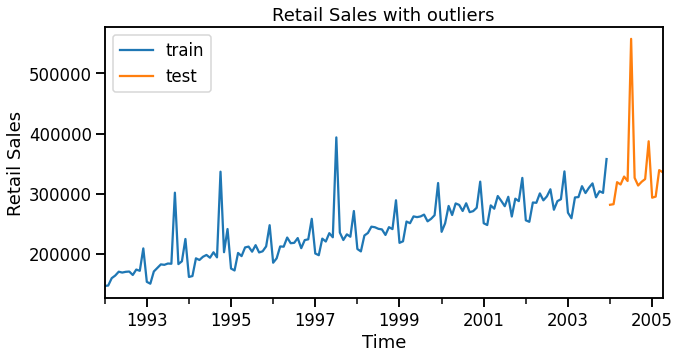

In [10]:
fig, ax = plt.subplots(figsize=[10, 5])
df_train["y"].plot(label="train", ax=ax)
df_test["y"].plot(label="test", ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")
ax.legend()

# Train a model with just trend and no dummy variables

In [11]:
from sklearn.linear_model import LinearRegression

In [12]:
features = ["trend"]

X_train = df_train[features]
y_train = df_train["y"].to_frame()

X_test = df_test[features]
y_test = df_test["y"].to_frame()

In [13]:
display(X_train.head())
display(y_train.head())

,trend
ds,
1992-01-01,0
1992-02-01,1
1992-03-01,2
1992-04-01,3
1992-05-01,4


,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


In [14]:
model = LinearRegression()
model.fit(X_train, y_train)
df_test["y_pred_no_dummy"] = model.predict(X_test)

/var/folders/lf/8j5fhbgs6w91njx87pb8mk2w0000gq/T/ipykernel_53880/2175678095.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_pred_no_dummy"] = model.predict(X_test)


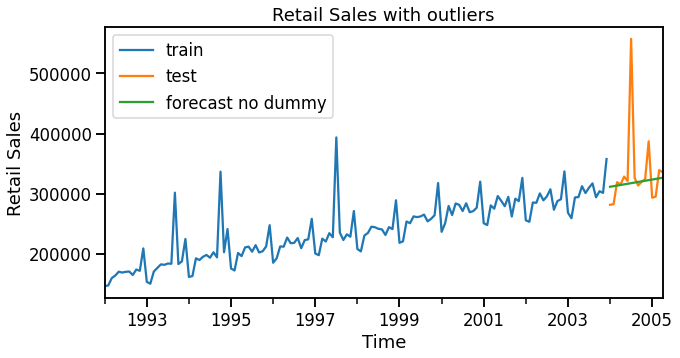

In [15]:
fig, ax = plt.subplots(figsize=[10, 5])
df_train["y"].plot(label="train", ax=ax)
df_test["y"].plot(label="test", ax=ax)
df_test["y_pred_no_dummy"].plot(label="forecast no dummy", ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")
ax.legend()

# Train a model with trend and dummy variables

In [16]:
features = ["trend", "is_outlier"]

X_train = df_train[features]
y_train = df_train["y"].to_frame()

X_test = df_test[features]
y_test = df_test["y"].to_frame()

In [17]:
display(X_train.head())
display(y_train.head())

,trend,is_outlier
ds,,
1992-01-01,0,0
1992-02-01,1,0
1992-03-01,2,0
1992-04-01,3,0
1992-05-01,4,0


,y
ds,
1992-01-01,146376.0
1992-02-01,147079.0
1992-03-01,159336.0
1992-04-01,163669.0
1992-05-01,170068.0


In [18]:
model = LinearRegression()
model.fit(X_train, y_train)
df_test["y_pred_w_dummy"] = model.predict(X_test)

/var/folders/lf/8j5fhbgs6w91njx87pb8mk2w0000gq/T/ipykernel_53880/2284433834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_pred_w_dummy"] = model.predict(X_test)


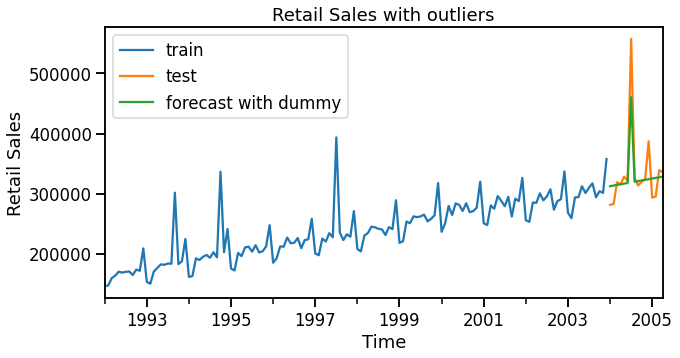

In [19]:
fig, ax = plt.subplots(figsize=[10, 5])
df_train["y"].plot(label="train", ax=ax)
df_test["y"].plot(label="test", ax=ax)
df_test["y_pred_w_dummy"].plot(label="forecast with dummy", ax=ax)
ax.set_title("Retail Sales with outliers")
ax.set_ylabel("Retail Sales")
ax.set_xlabel("Time")
ax.legend()

We can see that adding a dummy variable allows us to estimate the impact of future outlier or special events. This is useful when we know in advance when such events will occur.